### improvements 
1) Remove blinks and interpolate values using cubic splines
2) Blank filtering of data---Done-- maibe explore other filter
3) Frequency analysis of the signal??
4) Remove trials with z scores over [2,-2]
5) Convert time to seconds

In [34]:
import pandas as pd 
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import commons as cm
from data_curation import Normalization
nm=Normalization()


recording_location = r"C:\Users\Bolo\Desktop\Laboratorio\incipit\data\pupil_emotibit\ES0001_S002_PC_EM\data\pupil_labs\002"
image_location=r"../../../../data/pupil_emotibit/ES0001_S002_PC_EM/images_order"

def print_file_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print(f'{subindent}{f}')
print_file_structure(recording_location)


exported_pupil_csv = os.path.join(recording_location, 'exports', '000', 'pupil_positions.csv')
pupil_pd_frame = pd.read_csv(exported_pupil_csv)
exported_gaze_csv = os.path.join(recording_location, 'exports', '000', 'gaze_positions.csv')
gaze_pd_frame = pd.read_csv(exported_gaze_csv)
annotations_csv = os.path.join(recording_location, 'exports', '000', 'annotations.csv')
annotations_pd = pd.read_csv(annotations_csv)

002/
    annotation.pldata
    annotation_timestamps.npy
    blinks.pldata
    blinks_timestamps.npy
    eye0.intrinsics
    eye0.mp4
    eye0_lookup.npy
    eye0_timestamps.npy
    eye1.intrinsics
    eye1.mp4
    eye1_lookup.npy
    eye1_timestamps.npy
    fixations.pldata
    fixations_timestamps.npy
    gaze.pldata
    gaze_timestamps.npy
    info.player.json
    notify.pldata
    notify_timestamps.npy
    pupil.pldata
    pupil_timestamps.npy
    square_marker_cache
    surface_definitions_v01
    user_info.csv
    world.intrinsics
    world.mp4
    world_lookup.npy
    world_timestamps.npy
    exports/
        000/
            annotations.csv
            blink_detection_report.csv
            blinks.csv
            export_info.csv
            fixation_report.csv
            fixations.csv
            gaze_positions.csv
            pupil_gaze_positions_info.txt
            pupil_positions.csv
            world.mp4
            world_timestamps.csv
            world_timestamps.npy
  

In [35]:
pupil_pd_frame.columns

Index(['pupil_timestamp', 'world_index', 'eye_id', 'confidence', 'norm_pos_x',
       'norm_pos_y', 'diameter', 'method', 'ellipse_center_x',
       'ellipse_center_y', 'ellipse_axis_a', 'ellipse_axis_b', 'ellipse_angle',
       'diameter_3d', 'model_confidence', 'model_id', 'sphere_center_x',
       'sphere_center_y', 'sphere_center_z', 'sphere_radius',
       'circle_3d_center_x', 'circle_3d_center_y', 'circle_3d_center_z',
       'circle_3d_normal_x', 'circle_3d_normal_y', 'circle_3d_normal_z',
       'circle_3d_radius', 'theta', 'phi', 'projected_sphere_center_x',
       'projected_sphere_center_y', 'projected_sphere_axis_a',
       'projected_sphere_axis_b', 'projected_sphere_angle'],
      dtype='object')

## Lets extract the sampling frequency of the recording


In [98]:

import json
  
# Opening JSON file
f = open(recording_location'/info.player.json.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)
  
# Iterating through the json
# list
for i in data['emp_details']:
    print(i)
  
# Closing file
f.close()

'C:\\Users\\Bolo\\Desktop\\Laboratorio\\incipit\\data\\pupil_emotibit\\ES0001_S002_PC_EM\\data\\pupil_labs\\002'

In [36]:
from IPython.display import display

confidence_thr=0.99
 
# filter for 3d data
detector_3d_data = pupil_pd_frame[pupil_pd_frame.method == 'pye3d 0.3.0 real-time']

# skip first 5 seconds to allow for the 3D model to converge
# pupil_left_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>0.99), ['diameter','pupil_timestamp']]
# pupil_right_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']>0.99), ['diameter','pupil_timestamp']]

pupil_left_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>confidence_thr)]
pupil_right_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']>confidence_thr)]

filter_events=annotations_pd['label'].str.contains('Asset') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')
filter_assets=annotations_pd['label'].str.contains('Asset') 

filter_events_surprise= annotations_pd['label'].str.contains('Surprise')
filter_events_blank= annotations_pd['label'].str.contains('blank')


# pd.options.display.float_format = '{:.3f}'.format

print("eye0 (right eye) data:")
display(pupil_right_eye[['pupil_timestamp', 'eye_id', 'confidence', 'norm_pos_x', 'norm_pos_y', 'diameter_3d']].head(10))

print("eye1 data (left eye) data:")
display(pupil_left_eye[['pupil_timestamp', 'eye_id', 'confidence', 'norm_pos_x', 'norm_pos_y', 'diameter_3d']].head(10))

eye0 (right eye) data:


,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter_3d
40,14963.612106,0,1.000000,0.386152,0.600647,3.433041
44,14963.620093,0,0.997117,0.386382,0.600804,3.440457
93,14963.716120,0,0.994328,0.386449,0.601041,3.449854
101,14963.732101,0,1.000000,0.386593,0.601129,3.430699
126,14963.784066,0,1.000000,0.360289,0.558968,3.279102
128,14963.792129,0,1.000000,0.354970,0.554910,3.280315
135,14963.800065,0,1.000000,0.353633,0.556613,3.292825
136,14963.808131,0,1.000000,0.354417,0.557709,3.268855
141,14963.816080,0,1.000000,0.353835,0.556312,3.236991
145,14963.824134,0,1.000000,0.353366,0.555723,3.235702


eye1 data (left eye) data:


,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter_3d
3,14963.532146,1,1.0,0.305221,0.387696,3.554344
7,14963.540213,1,1.0,0.306098,0.388176,3.572560
11,14963.548129,1,1.0,0.306152,0.388124,3.577553
14,14963.556179,1,1.0,0.306005,0.388571,3.586922
17,14963.564011,1,1.0,0.306584,0.388046,3.616857
21,14963.572084,1,1.0,0.306660,0.388568,3.620500
25,14963.579989,1,1.0,0.306887,0.388388,3.616409
28,14963.588009,1,1.0,0.306617,0.388647,3.622452
33,14963.596015,1,1.0,0.306783,0.388604,3.619133
36,14963.604024,1,1.0,0.306974,0.388281,3.624435


In [37]:
%matplotlib qt

fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter_3d'])
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['confidence']*3)

ax.set_title('pupil diameter and confidence')    
plt.tight_layout()


## 

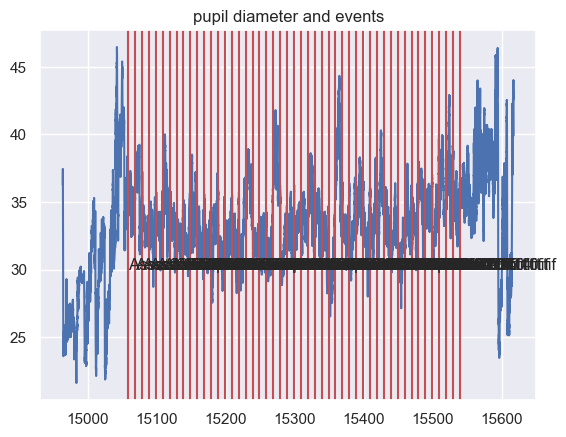

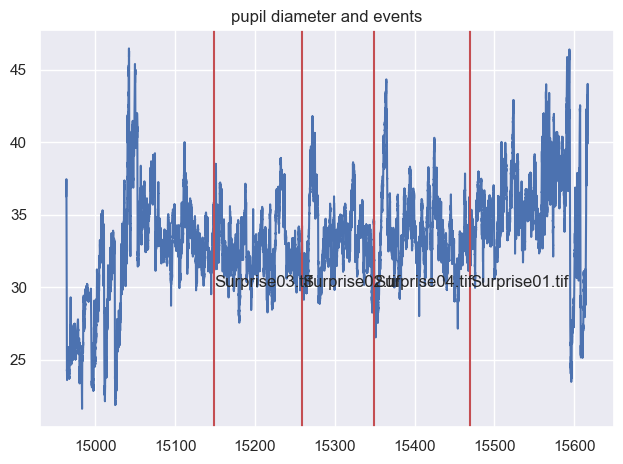

In [38]:
%matplotlib inline
sns.set_theme()
fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter'])
for  index, row in annotations_pd[filter_events].iterrows():
    plt.axvline(row['timestamp'], color='r', label='axvline - full height')
    ax.text((row['timestamp']),30,row['label'])
ax.set_title('pupil diameter and events')    

fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter'])
for  index, row in annotations_pd[filter_events_surprise].iterrows():
    plt.axvline(row['timestamp'], color='r', label='axvline - full height')
    ax.text((row['timestamp']),30,row['label'])
ax.set_title('pupil diameter and events')    
plt.tight_layout()

## Apply normalizations
### Filters

In [39]:
filter_events=annotations_pd['label'].str.contains('Asset') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')
filter_assets=annotations_pd['label'].str.contains('Asset') 

filter_events_surprise= annotations_pd['label'].str.contains('Surprise')
filter_events_blank= annotations_pd['label'].str.contains('blank')


### Global Variables

In [ ]:
pupil_df=pupil_right_eye


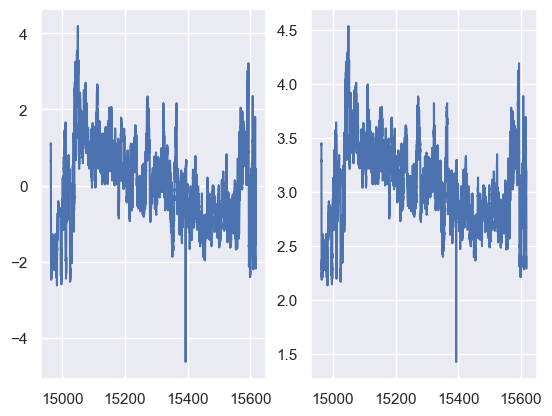

In [49]:
pupil_zscore=nm.normalize(values=pupil_df['diameter_3d'].reshape(pupil_df.),
                                            type='z_score').reshape(pupil_df)

#plot the results

fig, ax=plt.subplots(1,2)
ax[0].plot(pupil_df['pupil_timestamp'],pupil_zscore)
ax[1].plot(pupil_df['pupil_timestamp'],pupil_df['diameter_3d'],)

### Asset normalization

In [40]:
#common variables
pupil_df=pupil_right_eye
# pupil_df['speed']=abs(pupil_df['diameter_3d'].diff(periods=100).rolling(3).median())
y='diameter_3d'
win_norm=range(50)






In [41]:
# For Assets
event=annotations_pd.loc[filter_assets,['label']]
pupil_events_matrix=np.zeros([pupil_df.shape[0],len(event)])

for num,im in enumerate(event.values.flatten()):
    initial_anotation,end_anotation,index_annotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
   
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    win_blank=segmented_df.iloc[win_norm]

    pupil_events_matrix[0:len(segmented_df),num]=segmented_df[y]-win_blank['diameter_3d'].mean()#/abs(segmented_df[y].mean())


In [42]:
# For Surpriwe

event=annotations_pd.loc[filter_events_surprise,['label']]
pupil_surprise_matrix=np.zeros([pupil_df.shape[0],len(event)])

for num,im in enumerate(event.values.flatten()):
    initial_anotation,end_anotation,index_annotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
   
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    win_blank=segmented_df.iloc[win_norm]

    pupil_surprise_matrix[0:len(segmented_df),num]=segmented_df[y]-win_blank['diameter_3d'].mean()#/abs(segmented_df[y].mean())


### Do the plots

Text(0, 0.5, 'speed (s)')

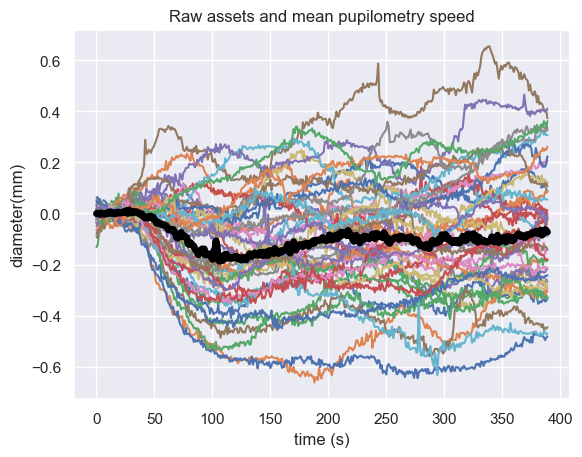

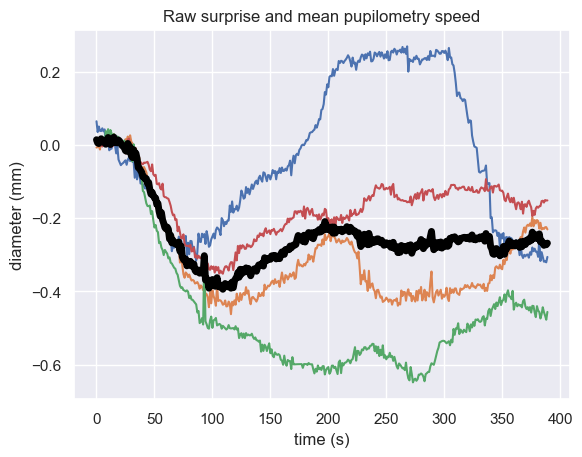

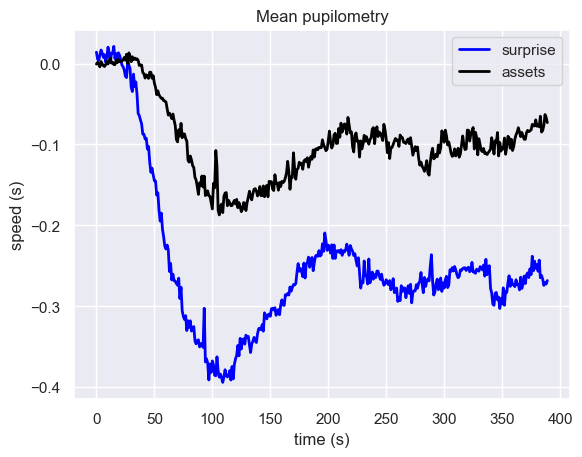

In [43]:
%matplotlib inline
window=range(10,400)

mat=pupil_events_matrix
fig, ax=plt.subplots(1,1)
ax.plot(mat[window])
ax.plot(np.median(mat[window,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter(mm)')


mat=pupil_surprise_matrix
fig, ax=plt.subplots(1,1)
ax.plot(mat[window,:])
ax.plot(np.median(mat[window,:],axis=1),linewidth=5,color='black')
ax.set_title('Raw surprise and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter (mm)')


fig, ax=plt.subplots(1,1)
ax.plot(np.median(pupil_surprise_matrix[window,:],axis=1),linewidth=2,color='blue')
ax.plot(np.median(pupil_events_matrix[window,:],axis=1),linewidth=2,color='black')

ax.legend(['surprise','assets'])
ax.set_title('Mean pupilometry')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

## Now lets calculate the speed of change from the normalized data

In [44]:

pupil_events_speed=np.abs(np.diff(pupil_events_matrix))
pupil_surprise_speed=np.abs(np.diff(pupil_surprise_matrix))

Text(0, 0.5, 'speed (s)')

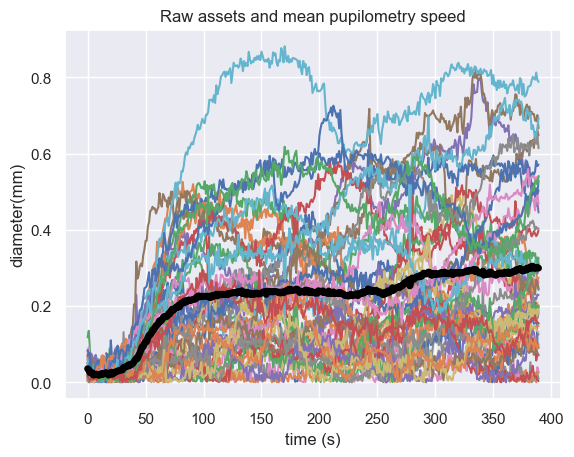

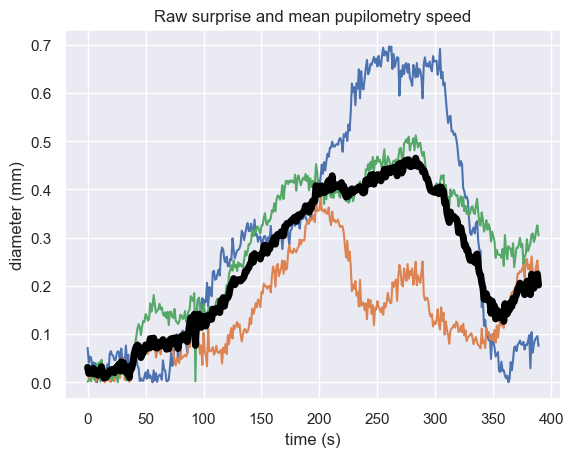

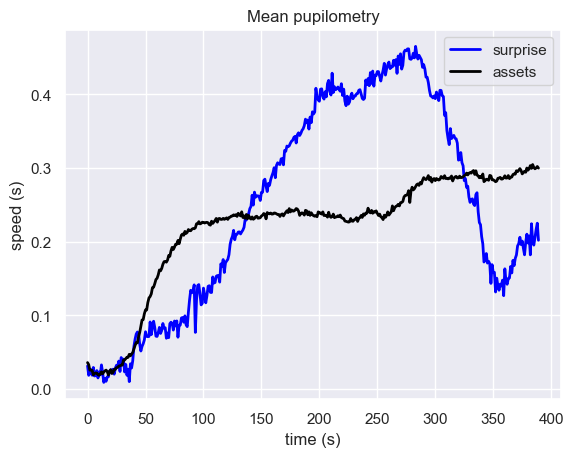

In [45]:
%matplotlib inline
window=range(10,400)

mat1=pupil_events_speed
mat2=pupil_surprise_speed

fig, ax=plt.subplots(1,1)
ax.plot(mat1[window])
ax.plot(np.mean(mat1[window,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter(mm)')

fig, ax=plt.subplots(1,1)
ax.plot(mat2[window,:])
ax.plot(np.mean(mat2[window,:],axis=1),linewidth=5,color='black')
ax.set_title('Raw surprise and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter (mm)')


fig, ax=plt.subplots(1,1)
ax.plot(np.mean(mat2[window,:],axis=1),linewidth=2,color='blue')
ax.plot(np.mean(mat1[window,:],axis=1),linewidth=2,color='black')

ax.legend(['surprise','assets'])
ax.set_title('Mean pupilometry')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

Exclude data that is over [2,-2] z scores


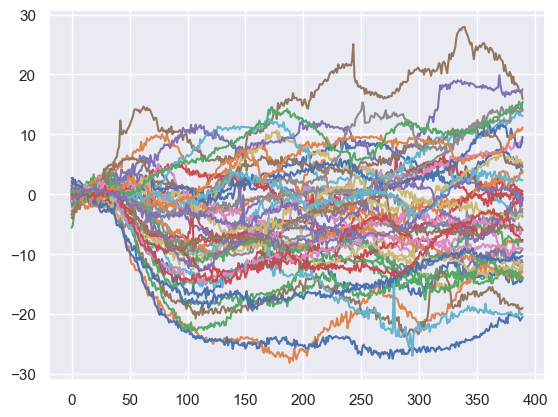

In [70]:
pupil_zscore=nm.normalize(values=pupil_events_matrix.reshape(pupil_events_matrix.size),
                                            type='z_score').reshape(pupil_events_matrix.shape)

fig, ax=plt.subplots(1,2)
ax.plot(pupil_zscore[window,:])
ax.plot(pupil_zscore[window,])

(array([[ 0.,  0.,  5.,  9.,  8., 24., 20.,  1.,  3.,  0.],
        [ 0.,  0.,  1.,  4., 17., 21., 20.,  6.,  0.,  1.],
        [ 0.,  0.,  0.,  6., 18., 22., 17.,  5.,  2.,  0.],
        [ 0.,  0.,  3., 11., 17., 17., 11., 11.,  0.,  0.],
        [ 0.,  0.,  1., 10., 19., 22., 13.,  2.,  3.,  0.],
        [ 0.,  0.,  1.,  9., 22., 19., 12.,  6.,  1.,  0.],
        [ 0.,  0.,  1., 10.,  9., 19., 16., 14.,  1.,  0.],
        [ 0.,  2.,  3.,  7., 18., 17., 17.,  5.,  1.,  0.],
        [ 0.,  0.,  1.,  5., 19., 23., 14.,  7.,  1.,  0.],
        [ 0.,  1.,  0., 10., 19., 15., 21.,  2.,  2.,  0.],
        [ 0.,  0.,  3.,  8., 20., 19., 13.,  5.,  2.,  0.],
        [ 0.,  1.,  1., 14., 20., 17.,  9.,  6.,  2.,  0.],
        [ 0.,  0.,  4.,  8., 17., 17., 15.,  5.,  3.,  1.],
        [ 0.,  0.,  5., 10., 12., 18., 20.,  4.,  1.,  0.],
        [ 0.,  0.,  0.,  8., 19., 23., 16.,  3.,  1.,  0.],
        [ 0.,  0.,  2., 16., 16., 17., 13.,  1.,  5.,  0.],
        [ 0.,  1.,  4.,  9., 11., 21., 1

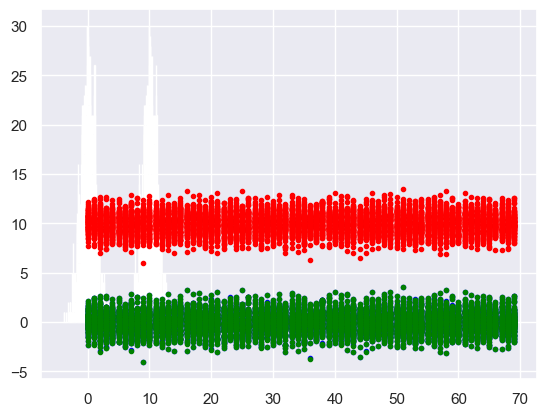

In [95]:
#test sfuntion
sigma=1
mu=10
data_normal=sigma*np.random.randn(70,100) +mu
data_norm=nm.normalize(values=data_normal.reshape(data_normal.size),
                                            type='z_score').reshape(data_normal.shape)
plt.plot(data_normal,'.',color='red')
plt.plot(data_norm,'.',color='blue')
plt.plot(data_normal-10,'.',color='green')


(array([[ 0.,  0.,  5.,  9.,  8., 24., 20.,  1.,  3.,  0.],
        [ 0.,  0.,  1.,  4., 17., 21., 20.,  6.,  0.,  1.],
        [ 0.,  0.,  0.,  6., 18., 22., 17.,  5.,  2.,  0.],
        [ 0.,  0.,  3., 11., 17., 17., 11., 11.,  0.,  0.],
        [ 0.,  0.,  1., 10., 19., 22., 13.,  2.,  3.,  0.],
        [ 0.,  0.,  1.,  9., 22., 19., 12.,  6.,  1.,  0.],
        [ 0.,  0.,  1., 10.,  9., 19., 16., 14.,  1.,  0.],
        [ 0.,  2.,  3.,  7., 18., 17., 17.,  5.,  1.,  0.],
        [ 0.,  0.,  1.,  5., 19., 23., 14.,  7.,  1.,  0.],
        [ 0.,  1.,  0., 10., 19., 15., 21.,  2.,  2.,  0.],
        [ 0.,  0.,  3.,  8., 20., 19., 13.,  5.,  2.,  0.],
        [ 0.,  1.,  1., 14., 20., 17.,  9.,  6.,  2.,  0.],
        [ 0.,  0.,  4.,  8., 17., 17., 15.,  5.,  3.,  1.],
        [ 0.,  0.,  5., 10., 12., 18., 20.,  4.,  1.,  0.],
        [ 0.,  0.,  0.,  8., 19., 23., 16.,  3.,  1.,  0.],
        [ 0.,  0.,  2., 16., 16., 17., 13.,  1.,  5.,  0.],
        [ 0.,  1.,  4.,  9., 11., 21., 1

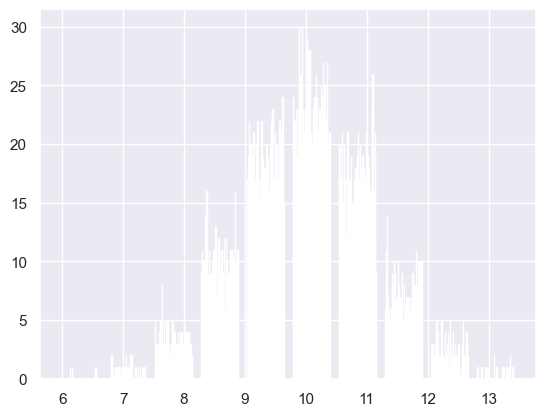

In [97]:
plt.hist(data_normal)


In [79]:
pupil_events_matrix.shape[0]

67325

In [60]:
r=a.reshape(pupil_events_matrix.shape)

In [55]:
pupil_events_matrix.shape[0]*pupil_events_matrix.shape[1]

3029625

In [59]:
pupil_events_matrix.shape

(67325, 45)